# Install libreries 

In [1]:
%pip install gensim nltk pandas seaborn keras
%pip install -U scikit-learn
%pip install tensorflow
%pip install gensim scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('floresta')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import word_tokenize
from nltk import pos_tag, word_tokenize
import pandas as pd
import numpy as np


import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package floresta to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package floresta is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Get Datasets from Gitbub

In [3]:
import pandas as pd

def read_and_convert_labels(file_url):
    # Read the file into a pandas DataFrame
    df = pd.read_csv(file_url, sep="\t")

    # Map labels to numerical values
    label_mapping = {'NO': 0, 'NOE': 1, 'OFG': 2, 'OFP': 3}
    df['label_num'] = df['label'].map(label_mapping)

    return df

# Train dataset
train_url = "https://raw.githubusercontent.com/fmplaza/OffendES/main/split_MeOffendES/training_set.tsv"
train_df = read_and_convert_labels(train_url)
print(train_df.head())

# Test dataset
test_url = "https://raw.githubusercontent.com/fmplaza/OffendES/main/split_MeOffendES/test_set.tsv"
test_df = read_and_convert_labels(test_url)
print(test_df.head())

# Validation dataset
val_url = "https://raw.githubusercontent.com/fmplaza/OffendES/main/split_MeOffendES/dev_set.tsv"
val_df = read_and_convert_labels(val_url)
print(val_df.head())


   comment_id                                            comment   
0       52564  En vez de la magia de mi melena, la magia de m...  \
1       32984  A ver, los milenials y la gente normal necesit...   
2       58447  Me encanta todo el contenido que haces se nota...   
3       10341  a Laura sige así que vales mucho más que 10 o ...   
4       53087  Y si no mes gusta Dalas, que hacen aquí,lárgue...   

       influencer influencer_gender      media label  label_num  
0           dalas               man  instagram    NO          0  
1  soyunapringada             woman    youtube    NO          0  
2       wildhater               man  instagram    NO          0  
3     lauraescane             woman    youtube    NO          0  
4           dalas               man  instagram    NO          0  
   comment_id                                           comment influencer   
0       54745                                   Lacasito moreno   wismichu  \
1        5595                    Yo pen

# Normalize data

In [4]:

def clean_text(text):
  text = ' '.join([ word for word in text.split(' ') if not word.startswith('@') ])
  text = re.sub(r"[^A-Za-z ]+", '', text) # keep only letters and spaces
  text = text.strip()
  return text

def remove_stop_words(text):
  stopwords_pt = stopwords.words('spanish')
  text_without_sw = [word for word in text.split(' ') if not word in stopwords_pt]
  return (" ").join(text_without_sw)

def lemmatization_nltk(text):
  lemmatizer = WordNetLemmatizer()
  words = nltk.word_tokenize(text, language='spanish')
  lemmas = [lemmatizer.lemmatize(p).lower() for p in words]
  return (" ").join(lemmas)


def remove_proper_nouns(text):
    words = []
    for word, tag in pos_tag(word_tokenize(text)):
        if tag != 'NNP' and tag != 'NNPS':  # Check for proper nouns tags
            words.append(word)
    return ' '.join(words)


def remove_urls(text):
    # Regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'

    # Remove URLs from the text using the pattern
    text_without_urls = re.sub(url_pattern, '', text)

    return text_without_urls

def normalize_text(text):
  text = remove_urls(text)
  text = clean_text(text)
  text = remove_proper_nouns(text)
  text = text.lower() 
  text = remove_stop_words(text)
  text = lemmatization_nltk(text)

  return text

In [5]:
def normalize_data(df, text_column):
    # Filter DataFrame and remove NaN values
    df_filtered = df[df[text_column].notna()]

    # Normalize text
    df_filtered['comment_clean'] = df_filtered[text_column].apply(normalize_text)

    return df_filtered

train_df = normalize_data(train_df, 'comment')
test_df = normalize_data(test_df, 'comment')
val_df = normalize_data(val_df, 'comment')
def convert_labels(df):
    # Create a new column 'label_num' and initialize with -1
    df['label_num'] = -1

    # Map labels to numerical values
    df.loc[df['label'] == 'NO', 'label_num'] = 0
    df.loc[df['label'] == 'NOE', 'label_num'] = 1
    df.loc[df['label'] == 'OFG', 'label_num'] = 2
    df.loc[df['label'] == 'OFP', 'label_num'] = 3       

    return df
train_df = convert_labels(train_df)
test_df = convert_labels(test_df)
val_df = convert_labels(val_df)

# Balance data for training

212
423
Balanced Train Data size: 30316
Balanced Test Data size: 13606
Balanced val Data size: 100
 Train Data size: 16710
 Test Data size: 13606


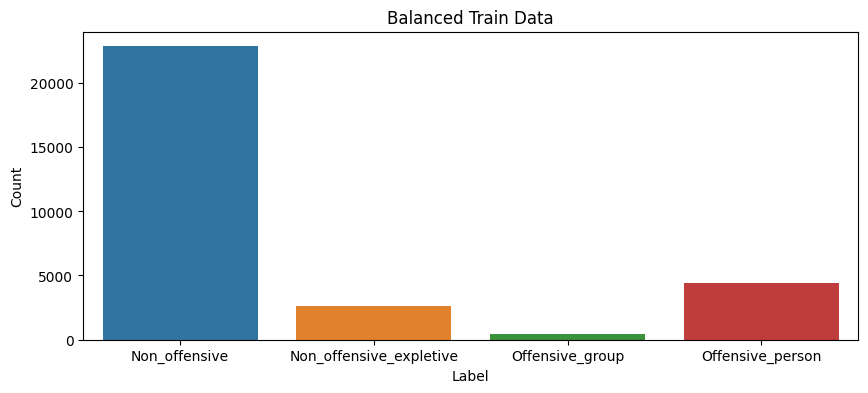

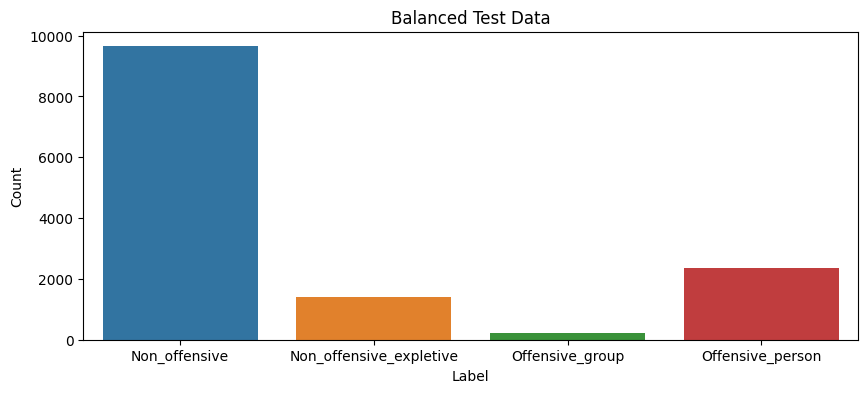

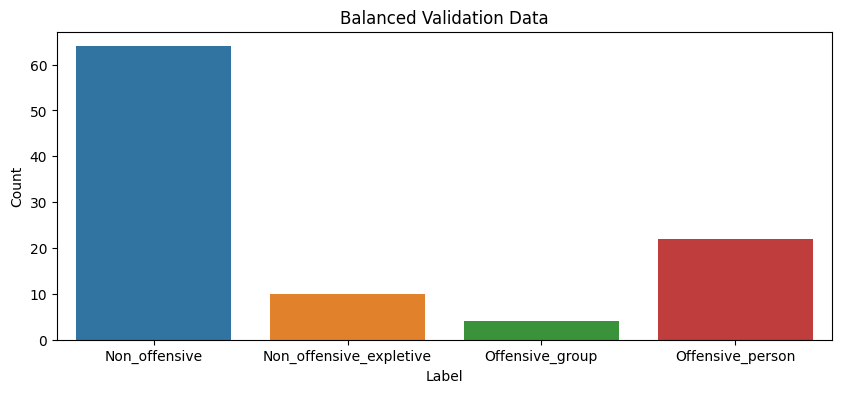

In [6]:

# Get the minimum count among all labels
min_count_train = train_df['label_num'].value_counts().min()
min_count_test = test_df['label_num'].value_counts().min()
print(min_count_train)

# Filter the training data to include an equal number of instances for each label
balanced_train_data = pd.concat([
    train_df[train_df['label_num'] == 0].sample(min_count_train , random_state=16),
    train_df[train_df['label_num'] == 1].sample(min_count_train , random_state=16),
    train_df[train_df['label_num'] == 2].sample(min_count_train , random_state=16),
    train_df[train_df['label_num'] == 3].sample(min_count_train , random_state=16)
])

# Filter the training data to include an equal number of instances for each label
balanced_train_data = pd.concat([
    train_df[train_df['label_num'] == 0],
    train_df[train_df['label_num'] == 1],
    train_df[train_df['label_num'] == 2],
    train_df[train_df['label_num'] == 3]
])

# Filter the test data to include an equal number of instances for each label
balanced_test_data = pd.concat([
    test_df[test_df['label_num'] == 0],
    test_df[test_df['label_num'] == 1],
    test_df[test_df['label_num'] == 2],
    test_df[test_df['label_num'] == 3]
])


# Filter the training data to include an equal number of instances for each label
"""balanced_train_data = pd.concat([
    balanced_train_data[balanced_train_data['label_num'] == 0].sample(min_count_train +2000, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 1].sample(min_count_train +2000 , random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 2].sample(min_count_train , random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 3].sample(min_count_train +2000 , random_state=16)
])"""
balanced_train_data =  pd.concat([balanced_train_data, balanced_test_data])
min_count_train = balanced_train_data['label_num'].value_counts().min()
print(min_count_train)
# Shuffle the data
balanced_train_data = balanced_train_data.sample(frac=1, random_state=16).reset_index(drop=True)
balanced_test_data = balanced_test_data.sample(frac=1, random_state=16).reset_index(drop=True)

# Print the sizes of the balanced datasets
print("Balanced Train Data size:", len(balanced_train_data))
print("Balanced Test Data size:", len(balanced_test_data))
print("Balanced val Data size:", len(val_df))
# Print the sizes of the balanced datasets
print(" Train Data size:", len(train_df))
print(" Test Data size:", len(test_df))

# Create a bar plot
plt.figure(figsize=(10, 4))
sns.countplot(x='label_num', data=balanced_train_data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balanced Train Data')
plt.xticks([0, 1, 2, 3], ['Non_offensive', 'Non_offensive_expletive', 'Offensive_group', 'Offensive_person'])
plt.show()

# Create a bar plot
plt.figure(figsize=(10, 4))
sns.countplot(x='label_num', data=balanced_test_data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balanced Test Data')
plt.xticks([0, 1, 2, 3], ['Non_offensive', 'Non_offensive_expletive', 'Offensive_group', 'Offensive_person'])
plt.show()

# Create a bar plot
plt.figure(figsize=(10, 4))
sns.countplot(x='label_num', data=val_df)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balanced Validation Data')
plt.xticks([0, 1, 2, 3], ['Non_offensive', 'Non_offensive_expletive', 'Offensive_group', 'Offensive_person'])
plt.show()

Balanced Train Data size: 3100


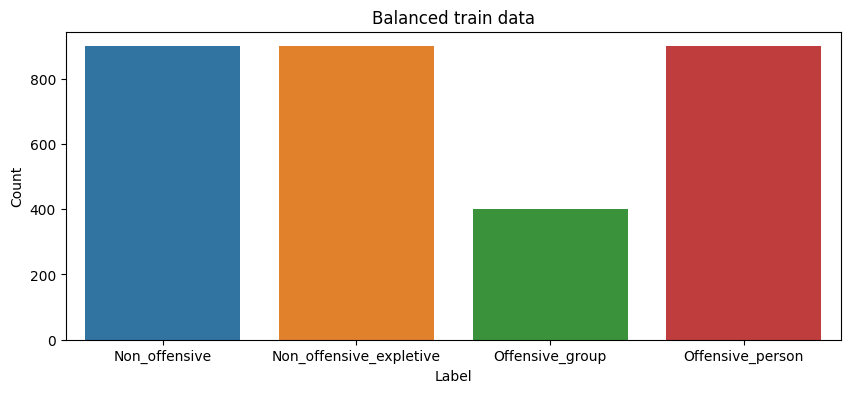

In [7]:
# Get the minimum count among all labels
min_count_train = 400  # Set the desired minimum count for each label

# Filter the training data to include a minimum number of instances for each label
filtered_train_data = pd.concat([
    balanced_train_data[balanced_train_data['label_num'] == 0].sample(min_count_train, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 1].sample(min_count_train, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 2].sample(min_count_train, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 3].sample(min_count_train, random_state=16)
])

# Add 500 more instances to specific labels
extra_train_data = pd.concat([
    balanced_train_data[balanced_train_data['label_num'] == 0].sample(500, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 1].sample(500, random_state=16),
    balanced_train_data[balanced_train_data['label_num'] == 3].sample(500, random_state=16)
])

# Combine the two subsets
balanced_train_data = pd.concat([filtered_train_data, extra_train_data])

# Shuffle the data
balanced_train_data = balanced_train_data.sample(frac=1, random_state=16).reset_index(drop=True)

# Print the size of the balanced dataset
print("Balanced Train Data size:", len(balanced_train_data))

# Create a bar plot
plt.figure(figsize=(10, 4))
sns.countplot(x='label_num', data=balanced_train_data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balanced train data')
plt.xticks([0, 1, 2, 3], ['Non_offensive', 'Non_offensive_expletive', 'Offensive_group', 'Offensive_person'])
plt.show()


In [8]:
print("Counts of each label_num:")
print(balanced_train_data['label_num'].value_counts())

Counts of each label_num:
label_num
0    900
3    900
1    900
2    400
Name: count, dtype: int64


# Split the data into training and validation sets

In [9]:
from sklearn.utils.class_weight import compute_class_weight

X = balanced_train_data['comment_clean']
y = balanced_train_data['label_num']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(class_weights_dict)

{0: 0.8611111111111112, 1: 0.8611111111111112, 2: 1.9375, 3: 0.8611111111111112}


# LSTM Word Embbeding

In [10]:
# Tokenizer for Word Embeddings
num_words = 10000  # Number of most frequent words to keep
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_val_encoded = tokenizer.texts_to_sequences(X_val)

max_sequence_length = max([len(sequence) for sequence in X_train_encoded])
print(max_sequence_length)
max_sequence_length=50
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_sequence_length, padding='post')
X_val_padded = pad_sequences(X_val_encoded, maxlen=max_sequence_length, padding='post')


217


In [11]:
from tensorflow.keras.layers import LSTM, Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping

# Build RNN model
embedding_dim = 100  # Dimension of word embeddings
model = Sequential([
    Embedding(num_words, embedding_dim, input_length=max_sequence_length),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  
])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to one-hot encoded format
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes=4)
y_val_encoded = to_categorical(y_val, num_classes=4)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using Word Embeddings
batch_size = 128
epochs = 50
model.fit(X_train_padded, y_train_encoded, class_weight=class_weights_dict,
          validation_data=(X_val_padded, y_val_encoded), epochs=epochs,
          batch_size=batch_size)#, callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 1,121,508
Trainable params: 1,121,508
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
17/17 [==============================] - 5s 142ms/step - loss: 1.3874 - accuracy: 0.2512 - val_loss: 1.4045 - val_accuracy: 0.1290
Epoch 2/50
17/17 [==================

30/30 [==============================] - 0s 6ms/step
Accuracy: 0.5827956989247312
Precision: 0.6644079598053566
Recall: 0.5827956989247312
F1 Score: 0.5700172267678466
Word Embeddings Encoding:
              precision    recall  f1-score   support

     Label 0       0.59      0.15      0.24       270
     Label 1       0.73      0.84      0.78       270
     Label 2       0.25      0.67      0.36       120
     Label 3       0.86      0.71      0.78       270

    accuracy                           0.58       930
   macro avg       0.61      0.59      0.54       930
weighted avg       0.66      0.58      0.57       930



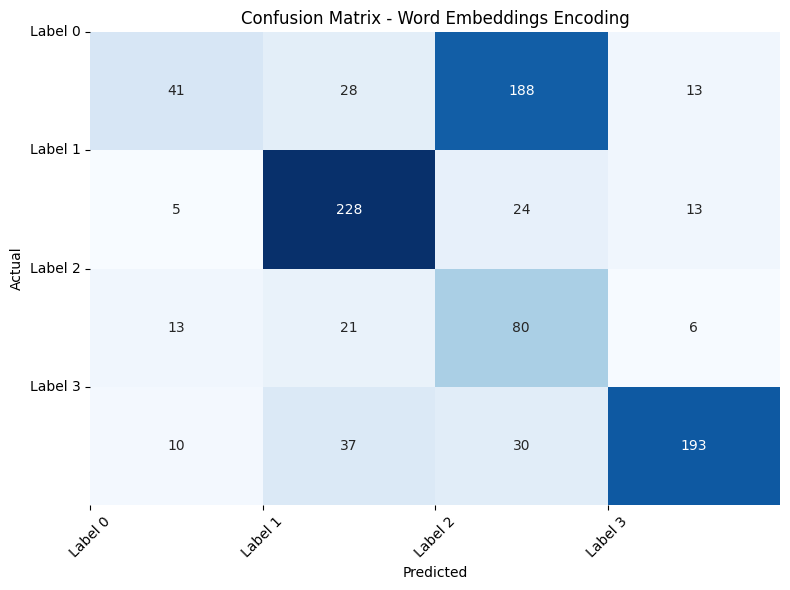

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


# Evaluate the model using the validation data
y_pred_emb = model.predict(X_val_padded)
y_pred_emb_int = np.argmax(y_pred_emb, axis=1)

# Calculate accuracy, precision, recall, and F1 Score
accuracy = accuracy_score(y_val, y_pred_emb_int)
precision = precision_score(y_val, y_pred_emb_int, average='weighted')
recall = recall_score(y_val, y_pred_emb_int, average='weighted')
f1 = f1_score(y_val, y_pred_emb_int, average='weighted')

# Print the values
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print classification report and confusion matrix
target_names = ['Label 0', 'Label 1', 'Label 2', 'Label 3']
print("Word Embeddings Encoding:")
print(classification_report(y_val, y_pred_emb_int, target_names=target_names))

# Print Confusion Matrix
conf_mat = confusion_matrix(y_val, y_pred_emb_int)

plt.figure(figsize=(8, 6)) 

# Plot confusion matrix as a heatmap
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Word Embeddings Encoding')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
plt.yticks(np.arange(len(target_names)), target_names, rotation=0)
plt.tight_layout()

plt.show()


# LSTM W2V

In [13]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and prepare data and labels (X, y)
X = balanced_train_data['comment_clean']
y = balanced_train_data['label_num']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load pre-trained Word2Vec model
word2vec_model = api.load("word2vec-google-news-300")

# Tokenize and encode sentences using Keras Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_val_encoded = tokenizer.texts_to_sequences(X_val)

# Convert sequences to padded sequences
max_sequence_length = 50
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_sequence_length, padding='post')
X_val_padded = pad_sequences(X_val_encoded, maxlen=max_sequence_length, padding='post')

# Build RNN model with Word2Vec embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec_model.vector_size))
for word, index in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[index] = word2vec_model.get_vector(word)

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=word2vec_model.vector_size,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              input_length=max_sequence_length, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes=4)
y_val_encoded = to_categorical(y_val, num_classes=4)

# Train the model using Word2Vec embeddings
batch_size = 128
epochs = 60
model.fit(X_train_padded, y_train_encoded,
          validation_data=(X_val_padded, y_val_encoded),
          epochs=epochs, batch_size=batch_size)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 300)           1952700   
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2,176,608
Trainable params: 223,908
Non-trainable params: 1,952,700
_________________________________________________________________
Epoch 1/60
20/20 [==============================] - 6s 162ms/step - loss: 1.3499 - accuracy: 0.3206 - val_loss: 1.2931 - val_accuracy: 0.3903
Epoch 2/60
20/20 [==========

20/20 [==============================] - 1s 22ms/step
Accuracy: 0.65
Precision: 0.704158798860379
Recall: 0.65
F1 Score: 0.6424104325409035
Word Embeddings Encoding:
              precision    recall  f1-score   support

     Label 0       0.84      0.60      0.70       180
     Label 1       0.79      0.68      0.73       180
     Label 2       0.67      0.23      0.34        80
     Label 3       0.50      0.86      0.63       180

    accuracy                           0.65       620
   macro avg       0.70      0.59      0.60       620
weighted avg       0.70      0.65      0.64       620

Confusion Matrix:
[[108   3   2  67]
 [  2 123   3  52]
 [ 15  11  18  36]
 [  4  18   4 154]]


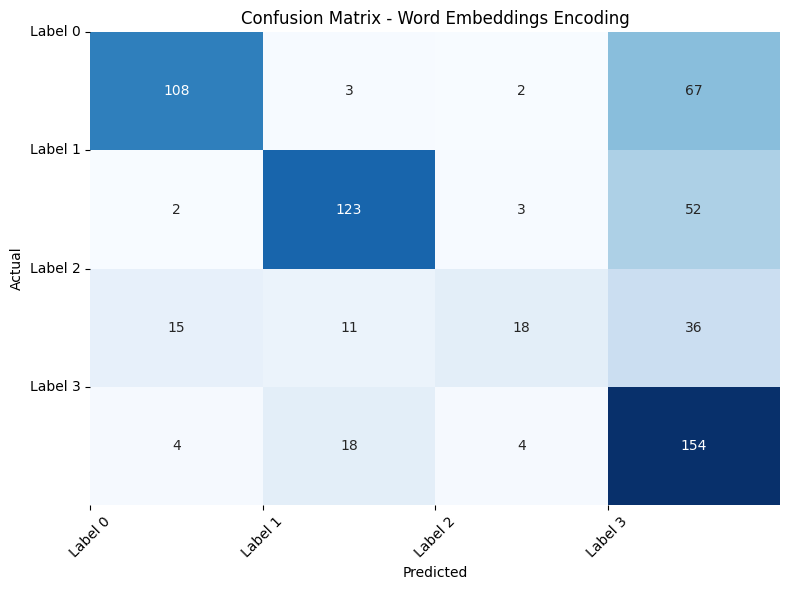

In [14]:
# Evaluate the model using the validation data
y_pred_emb = model.predict(X_val_padded)
y_pred_emb_int = np.argmax(y_pred_emb, axis=1)

# Calculate accuracy, precision, recall, and F1 Score
accuracy = accuracy_score(y_val, y_pred_emb_int)
precision = precision_score(y_val, y_pred_emb_int, average='weighted')
recall = recall_score(y_val, y_pred_emb_int, average='weighted')
f1 = f1_score(y_val, y_pred_emb_int, average='weighted')

# Print the values
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print classification report and confusion matrix
target_names = ['Label 0', 'Label 1', 'Label 2', 'Label 3']
print("Word Embeddings Encoding:")
print(classification_report(y_val, y_pred_emb_int, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_emb_int))

# Plot confusion matrix as a heatmap
conf_mat = confusion_matrix(y_val, y_pred_emb_int)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Word Embeddings Encoding')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
plt.yticks(np.arange(len(target_names)), target_names, rotation=0)
plt.tight_layout()
plt.show()


# Keras tokanitxacio

In [25]:
# Import functions from sklearn library
from sklearn.model_selection import train_test_split
# our own normalization
balanced_train_data = balanced_train_data[balanced_train_data['comment_clean'].notna()] # removing nan values
balanced_train_data['comment_clean_2'] = balanced_train_data['comment_clean'].apply(normalize_text)

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(balanced_train_data, test_size=0.3,random_state=42)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 2170
Test Data size 930


In [26]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tweets_column='comment_clean_2'

tokenizer.fit_on_texts(train_data[tweets_column])
word_index = tokenizer.word_index
print(word_index)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

{'si': 1, 'mierda': 2, 'm': 3, 'video': 4, 'gente': 5, 'persona': 6, 'da': 7, 'hacer': 8, 'ser': 9, 'puto': 10, 'solo': 11, 'verdad': 12, 'est': 13, 'mejor': 14, 'ver': 15, 'q': 16, 'puta': 17, 'tan': 18, 'hace': 19, 'ma': 20, 'bien': 21, 'vida': 22, 'va': 23, 't': 24, 'vdeo': 25, 'dice': 26, 'xd': 27, 'coo': 28, 'siempre': 29, 'ahora': 30, 'mal': 31, 'cosas': 32, 'qu': 33, 'tambin': 34, 'mundo': 35, 'mismo': 36, 'canal': 37, 'dalas': 38, 'parece': 39, 'asco': 40, 'puede': 41, 'toda': 42, 'alguien': 43, 'aos': 44, 'amo': 45, 'decir': 46, 's': 47, 'nadie': 48, 'creo': 49, 'vdeos': 50, 'cada': 51, 'madre': 52, 'bueno': 53, 'tipo': 54, 'comentarios': 55, 'pa': 56, 'cuenta': 57, 'pues': 58, 'v': 59, 'vez': 60, 'pasa': 61, 'haces': 62, 'tener': 63, 'gusta': 64, 'nunca': 65, 'dinero': 66, 'quiero': 67, 'menos': 68, 'buena': 69, 'puedo': 70, 'digo': 71, 'dan': 72, 'igual': 73, 'haciendo': 74, 'cara': 75, 'peor': 76, 'visto': 77, 'hacen': 78, 'veces': 79, 'tiempo': 80, 'pena': 81, 've': 82, 'a

In [27]:
from keras.utils import pad_sequences

# The tokens are converted into sequences and then passed to the pad_sequences() function
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data[tweets_column]), maxlen = 50)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data[tweets_column]), maxlen = 50) 
y_train = train_data['label_num']
y_test = test_data['label_num']

print(y_train.shape)
print(y_test.shape)

(2170,)
(930,)


In [28]:
from keras import Sequential
from keras.layers import Dense,SimpleRNN,Embedding,Flatten, LSTM, Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, output_dim=50, input_length=50))
model.add(SimpleRNN(128,return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(4,activation='softmax'))

model.summary() 
# Convertir les etiquetes a vectors one-hot
y_train_onehot = to_categorical(y_train, num_classes=4)
y_test_onehot = to_categorical(y_test, num_classes=4)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 50)            310400    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 128)           22912     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 345,924
Trainable params: 345,924
Non-trainable params: 0
_________________________________________________________________


In [32]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train_onehot, epochs=60, validation_data=(x_test,y_test_onehot))

Epoch 1/60
68/68 [==============================] - 3s 21ms/step - loss: 0.0527 - accuracy: 0.9783 - val_loss: 1.3118 - val_accuracy: 0.6860
Epoch 2/60
68/68 [==============================] - 1s 17ms/step - loss: 0.0501 - accuracy: 0.9760 - val_loss: 1.2239 - val_accuracy: 0.7097
Epoch 3/60
68/68 [==============================] - 1s 17ms/step - loss: 0.0489 - accuracy: 0.9779 - val_loss: 1.3017 - val_accuracy: 0.6914
Epoch 4/60
68/68 [==============================] - 1s 17ms/step - loss: 0.0478 - accuracy: 0.9806 - val_loss: 1.3245 - val_accuracy: 0.6946
Epoch 5/60
68/68 [==============================] - 1s 21ms/step - loss: 0.0484 - accuracy: 0.9797 - val_loss: 1.3336 - val_accuracy: 0.6978
Epoch 6/60
68/68 [==============================] - 1s 17ms/step - loss: 0.0478 - accuracy: 0.9806 - val_loss: 1.3025 - val_accuracy: 0.6968
Epoch 7/60
68/68 [==============================] - 1s 17ms/step - loss: 0.0469 - accuracy: 0.9802 - val_loss: 1.3349 - val_accuracy: 0.7011
Epoch 8/60
68

30/30 [==============================] - 0s 4ms/step
Accuracy: 0.6817204301075269
Accuracy: 0.6817204301075269
Precision: 0.7111814003580295
Recall: 0.6817204301075269
F1 Score: 0.6943982519947615
Keras Embeddings Encoding:
              precision    recall  f1-score   support

     Label 0       0.79      0.74      0.76       278
     Label 1       0.75      0.69      0.72       271
     Label 2       0.24      0.36      0.29       105
     Label 3       0.78      0.74      0.76       276

    accuracy                           0.68       930
   macro avg       0.64      0.63      0.63       930
weighted avg       0.71      0.68      0.69       930

Confusion Matrix:
[[206  20  39  13]
 [ 18 187  43  23]
 [ 24  21  38  22]
 [ 13  23  37 203]]


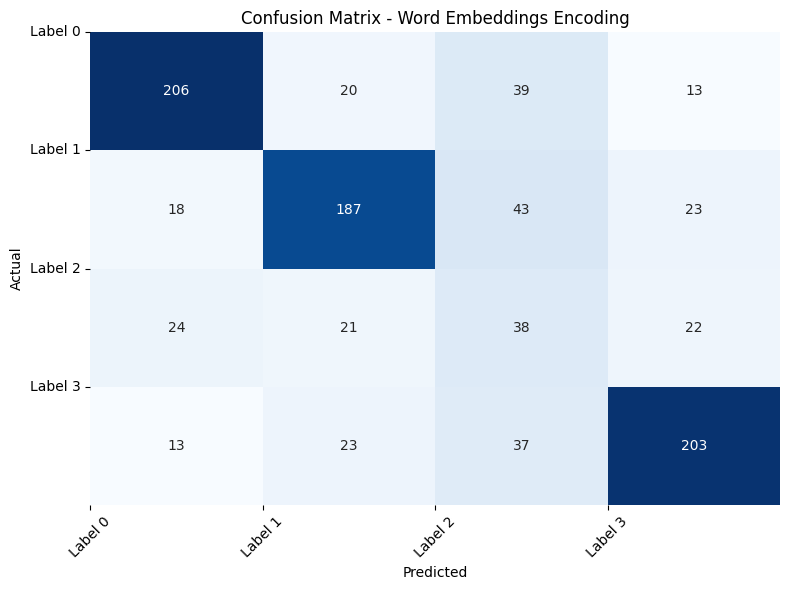

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the model using the validation data
y_pred_emb = model.predict(x_test)
y_pred_emb_int = np.argmax(y_pred_emb, axis=1)

# Calculate accuracy, precision, recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred_emb_int)
precision = precision_score(y_test, y_pred_emb_int, average='weighted')
recall = recall_score(y_test, y_pred_emb_int, average='weighted')
f1 = f1_score(y_test, y_pred_emb_int, average='weighted')


# Print accuracy
accuracy = accuracy_score(y_test, y_pred_emb_int)
print("Accuracy:", accuracy)

# Print the values
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print classification report and confusion matrix
target_names = ['Label 0', 'Label 1', 'Label 2', 'Label 3']
print("Keras Embeddings Encoding:")
print(classification_report(y_test, y_pred_emb_int, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_emb_int))


# Plot confusion matrix as a heatmap
conf_mat = confusion_matrix(y_test, y_pred_emb_int)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Word Embeddings Encoding')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
plt.yticks(np.arange(len(target_names)), target_names, rotation=0)
plt.tight_layout()
plt.show()


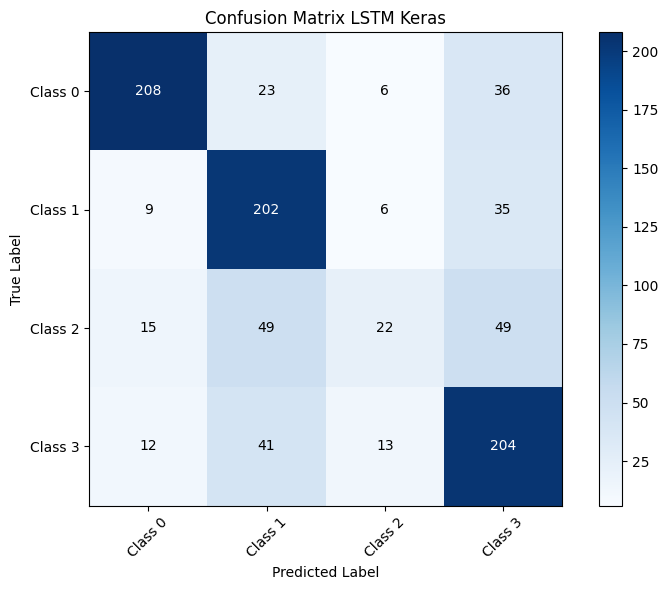

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Define the confusion matrix data
confusion_matrix = np.array([[208, 23, 6, 36],
                             [9, 202, 6, 35],
                             [15, 49, 22, 49],
                             [12, 41, 13, 204]])

# Create a figure and axis
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix LSTM Keras')
plt.colorbar()

# Define the tick marks and axis labels
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add labels to the cells
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

# Set labels for the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.tight_layout()
plt.show()
